In [ ]:
# built-in modules
# 3-rd party modules
import pandas as pd
import numpy as np
from matplotlib import pyplot
# local modules
import footprint_tools as fp_tools

from data

In [2]:
# read data
data = (fp_tools.read_from_url('https://citydata.icos-cp.eu/licence_accept?ids=%5B%22BKqa7hKRd7IHGee7WHPOqMEN%22%5D', na_values=[-9999])
 .query('TIMESTAMP_START.astype("str").str.startswith("20240424")')
 .assign(TIMESTAMP=lambda x: (pd.to_datetime(x['TIMESTAMP_START'], format='%Y%m%d%H%M', utc=True)-pd.Timedelta('60Min')).dt.strftime('%y%m%d%H%M').astype(int))
 )

# calculate footprint (data -> footprint dictionary)
dic = fp_tools.calculate_footprint(data, by='TIMESTAMP', zm=102.5, z0=1, pblh=1500)

# convert to netcdf (dictionary -> netcdf)
crs = fp_tools.rasterio.crs.CRS.from_string('EPSG:3035')
nc = fp_tools.convert_to_nc(dic, 
                            Tower_Location_Latitude=48.88514,
                            Tower_Location_Longitude=2.42222,
                            Tower_Location_CRS="EPSG:4326",
                            timestep={'timezone': 'UTC'},
                            Coordinate_Reference_System=crs.to_string(),
                            crs_projection4=crs.to_proj4(),
                            crs_wkt=crs.to_wkt())
nc['wind_dir'] = ('timestep', pd.merge(pd.DataFrame({'TIMESTAMP': nc.timestep.to_numpy()}),
                                       data[['TIMESTAMP', 'WD']], on='TIMESTAMP', how='left').WD)
fp_tools.center_footprint(nc)

# convert to tif (netcdf/dictionary -> tif)
tif = fp_tools.convert_to_tif(nc)

# convert to structured data (data -> structured data)
from_data = fp_tools.utils.structuredData(data=data,
                                          dic=dic,
                                          nc=nc,
                                          tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')
pyplot.close()

cannot access local variable 'psi_f' where it is not associated with a value


from .nc

In [3]:
#'sample/output/data_to_nc/FR-Rmv_footprint_230215.nc', 'sample/input/paris_footprint_240430.nc'
nc = fp_tools.read_handler('sample/input/paris_footprint_240424.nc')

# convert to dict (netcdf -> dictionary)
dic = fp_tools.convert_to_dict(nc, 20240424)

# convert to tif (netcdf/dictionary -> tif)
tif = fp_tools.convert_to_tif(nc)

# convert to structured data (data -> structured data)
from_nc = fp_tools.utils.structuredData(dic=dic,
                                        nc=nc,
                                        tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')
pyplot.close()

from .tif

In [4]:
tif = fp_tools.read_handler('sample/output/paris_footprint_from_data.tif')
#tif = fp_tools.utils.reproject_tif(tif, 4326)

# convert to dict (tif -> dictionary)
dic = fp_tools.convert_to_dict(tif, 202404300030)

# convert to netcdf (dictionary -> netcdf)
lat, lon = fp_tools.utils.transform_coordinates(
    *fp_tools.utils.find_middle_point(tif.bounds), crs_in=tif.crs, crs_out="EPSG:4326")

nc = fp_tools.convert_to_nc(dic,
                            Tower_Location_Latitude=lat,
                            Tower_Location_Longitude=lon,
                            Tower_Location_CRS="EPSG:4326",
                            timestep={'timezone': 'UTC'},
                            Coordinate_Reference_System=tif.crs.to_string(),
                            crs_projection4=tif.crs.to_proj4(),
                            crs_wkt=tif.crs.to_wkt())


# convert to structured data (data -> structured data)
from_tif = fp_tools.utils.structuredData(dic=dic,
                                         nc=nc,
                                         tif=tif)

# plot tif
pyplot.imshow(tif.read(1), cmap='pink')

pyplot.close()

testing

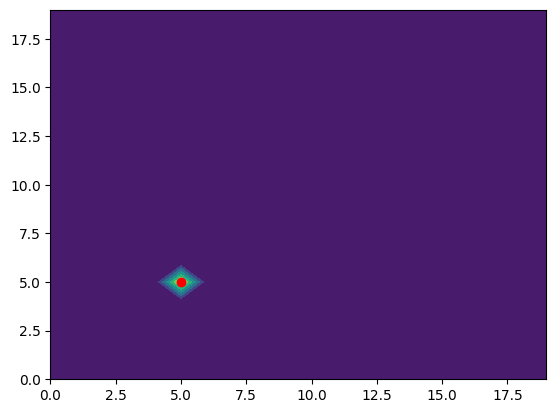

In [9]:
d = np.zeros((20,20))
d[5,5] = 1
pyplot.contourf(d)
pyplot.scatter(*fp_tools.utils.find_peak(d), c='red')

comparison

330.7
330.5


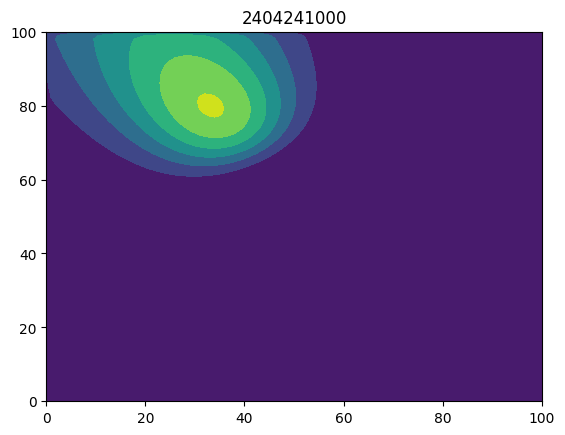

(lat,lon) (lon,lat)
329.9


(750.0, 850.0)

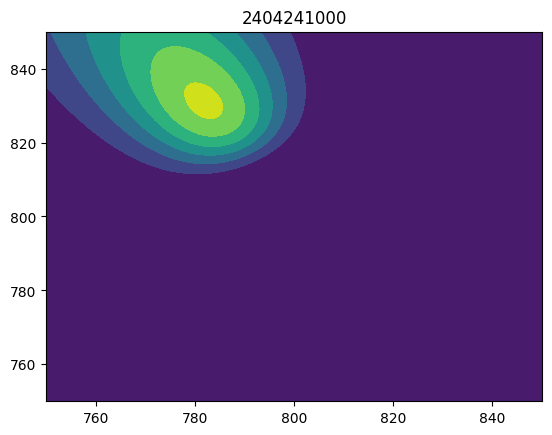

In [ ]:
from matplotlib import pyplot


def angle(x0, y0, x, y, precision=1):
  (dx, dy) = (x0-x, y-y0)
  # np.atan(float(dy)/float(dx))
  angle = np.degrees(np.atan2(float(dy), float(dx)))
  return round(360 - (90 - angle) % 360, precision)


ix = 22
ix_d = int(np.where(from_data.nc.timestep == int(
    from_data.data.TIMESTAMP.to_list()[ix]))[0][0])
ix_n = int(np.where(from_nc.nc.timestep == int(
    from_data.data.TIMESTAMP.to_list()[ix]))[0][0])

print(from_data.nc.wind_dir.to_numpy()[ix_d])
print(fp_tools.utils.infer_convention_from_affine(from_data.tif.transform),
      fp_tools.utils.infer_convention_from_nc(from_data.nc))
print(fp_tools.utils.infer_convention_from_affine(from_nc.tif.transform),
      fp_tools.utils.infer_convention_from_nc(from_nc.nc))

pyplot.title(from_data.nc.timestep.to_numpy()[ix_d])
d = from_data.tif.read(ix_d+1)
# d[0, :] = np.linspace(0,1,len(d[0]))
d = fp_tools.utils.transformer_convention(
    from_data.nc, '(lat,lon)', 'bottom-left')(d)
print(angle(50, 50, *fp_tools.utils.find_peak(d)[::-1]))
pyplot.contourf(d)
pyplot.show()

pyplot.title(from_nc.nc.timestep.to_numpy()[ix_n])
d = from_nc.tif.read(ix_n+1)
# d[0, :] = np.linspace(0,1,len(d[0]))
d = fp_tools.utils.transformer_convention(
    from_nc.nc, '(lat,lon)', 'bottom-left')(d)
print(angle(800, 800, *fp_tools.utils.find_peak(d)[::-1]))
pyplot.contourf(d)
pyplot.xlim(750, 850)
pyplot.ylim(750, 850)

Target angle: 330.7
330.5
329.9


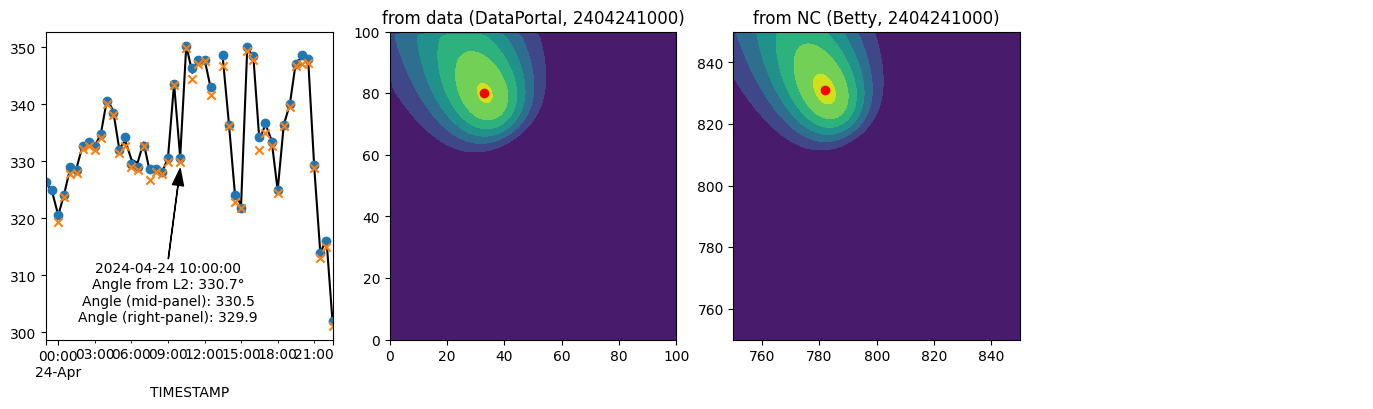

In [10]:
from matplotlib import pyplot as plt
import math

def angle(x0, y0, x, y, precision=1):
  (dx, dy) = (x0-x, y-y0)
  angle = np.degrees(np.atan2(float(dy), float(dx)))#np.atan(float(dy)/float(dx))
  return round(360 - (90 - angle) % 360, precision)

plt.subplots(1,4, figsize=(17,4))
thisdata = from_data.data.copy()
thisdata['TIMESTAMP'] = pd.to_datetime(thisdata['TIMESTAMP'], format="%y%m%d%H%M")
thisdata.set_index('TIMESTAMP', inplace=True)

ix = 22
ix_d = np.where(from_data.nc.timestep == int(thisdata.index[ix].strftime('%y%m%d%H%M')))[0][0]
ix_n = np.where(from_nc.nc.timestep == int((thisdata.index[ix]).strftime('%y%m%d%H%M')))[0][0]

plt.subplot(1,4,1)
thisdata['WD'].plot(c='k', zorder=-9)
plt.scatter(pd.to_datetime(from_data.nc.timestep, format='%y%m%d%H%M'),
            
         [angle(50, 50, *fp_tools.utils.find_peak(from_data.nc.footprint[jx].T)) for jx in range(len(from_nc.nc.footprint))],
         marker='o')
plt.scatter(pd.to_datetime(from_nc.nc.timestep, format='%y%m%d%H%M'),
         [angle(800, 800, *fp_tools.utils.find_peak(from_nc.nc.footprint[jx])) for jx in range(len(from_nc.nc.footprint))],
         marker='x', c='C1')
#plt.scatter(thisdata.index[ix], thisdata['WD'].iloc[ix], c='red')
plt.annotate(f'{thisdata.index[ix]}\nAngle from L2: {thisdata['WD'].iloc[ix]}°\nAngle (mid-panel): {angle(50, 50, *fp_tools.utils.find_peak(from_data.nc.footprint[ix_d].T))}\nAngle (right-panel): {angle(800, 800, *fp_tools.utils.find_peak(from_nc.nc.footprint[ix_n]))}',
             xy = (thisdata.index[ix], thisdata['WD'].iloc[ix]-2),
             xytext = (thisdata.index[20], 302),
             arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
             horizontalalignment = 'center')
print('Target angle:', thisdata['WD'].iloc[ix])

plt.subplot(1,4,2)
plt.title(f'from data (DataPortal, {from_data.nc.timestep[ix_d].to_numpy()})')
plt.contourf(from_data.nc.footprint[ix_d])
plt.scatter(*fp_tools.utils.find_peak(from_data.nc.footprint[ix_d].T), c='red')
print(angle(50, 50, *fp_tools.utils.find_peak(from_data.nc.footprint[ix_d].T)))

plt.subplot(1,4,3)
plt.title(f'from NC (Betty, {from_nc.nc.timestep[ix_n].to_numpy()})')
plt.contourf(from_nc.nc.footprint[ix_n].T)
plt.scatter(*fp_tools.utils.find_peak(from_nc.nc.footprint[ix_n]), c='red')
#plt.scatter(*[x-8 for x in np.unravel_index(from_nc.data.footprint[20].argmax(), from_nc.data.footprint[20].shape)], c='red')
print(angle(800, 800, *fp_tools.utils.find_peak(from_nc.nc.footprint[ix_n])))
plt.ylim(750,850)
plt.xlim(750,850)

plt.subplot(1,4,4)
plt.axis('off')
plt.show()